## **Import Libraries**


In [ ]:
## Conection with Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

##**Training with Initial Data**

In [ ]:
# Define the directories for the training, validation, and testing data:
train_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_WPP/train/'
val_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_WPP/val/'
test_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_WPP/test/'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generators for the training, validation, and testing data:
batch_size = 128
img_dims = 224

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224),
                                                    batch_size=batch_size, class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224),
                                                batch_size=batch_size, class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224),
                                                  batch_size=batch_size, class_mode='categorical')

Found 3082 images belonging to 4 classes.
Found 385 images belonging to 4 classes.
Found 385 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
vgg_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in vgg_model.layers:
    layer.trainable = False

x = tf.keras.layers.Flatten()(vgg_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model_1 = tf.keras.models.Model(vgg_model.input, x)
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 5
history_1 = model_1.fit(train_generator, epochs=epochs,steps_per_epoch=train_generator.samples // batch_size, 
                        validation_data=val_generator,validation_steps=val_generator.samples // batch_size)


#model_1.save('VGG_model_1_WPP.h5')
test_loss_1, test_acc_1 = model_1.evaluate(test_generator)
print('Test accuracy:', test_acc_1)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/5
24/24 [==============================] - 1983s 82s/step - loss: 1.2381 - accuracy: 0.6364 - val_loss: 0.3534 - val_accuracy: 0.8524
Epoch 2/5
24/24 [==============================] - 1924s 81s/step - loss: 0.4241 - accuracy: 0.8125 - val_loss: 0.3023 - val_accuracy: 0.8762
Epoch 3/5
24/24 [==============================] - 1958s 82s/step - loss: 0.3619 - accuracy: 0.8412 - val_loss: 0.2877 - val_accuracy: 0.8915
Epoch 4/5
24/24 [==============================] - 1891s 79s/step - loss: 0.3164 - accuracy: 0.8619 - val_loss: 0.2932 - val_accuracy: 0.8819
Epoch 5/5
4/4 [==============================] - 216s 48s/step - loss: 0.1899 - accuracy: 0.9155
Test accuracy: 0.9154545378684998


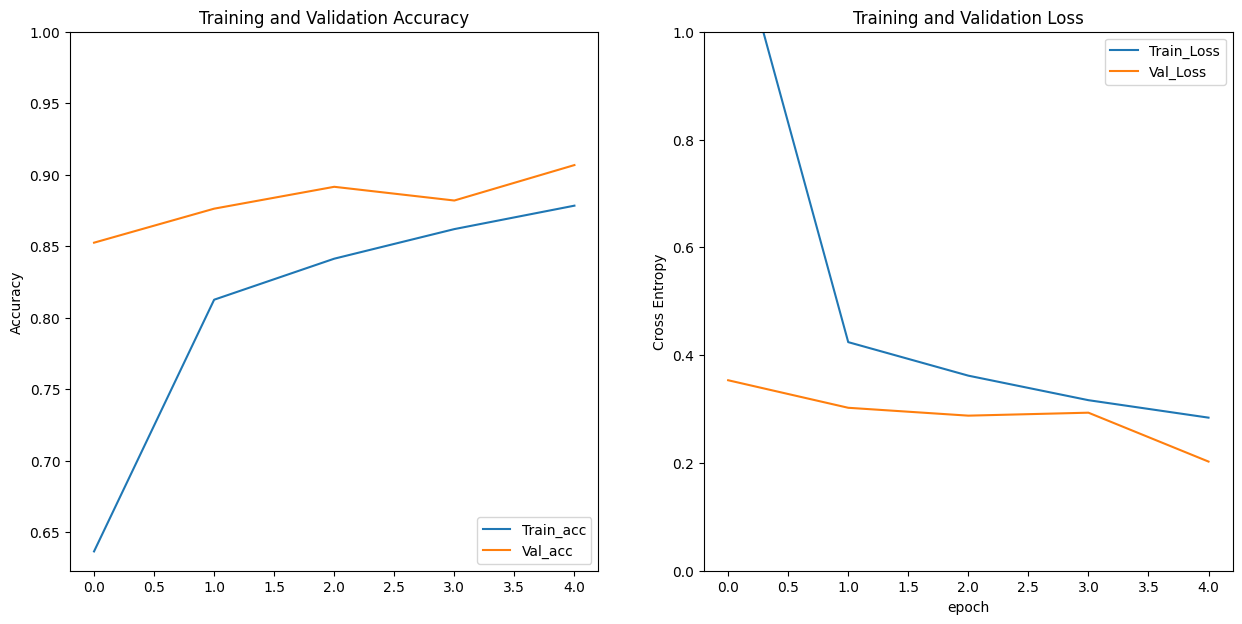

In [ ]:
### Loss and accuracy plot
acc_mob = history_1.history['accuracy']
val_acc_mob = history_1.history['val_accuracy']

loss_mob = history_1.history['loss']
val_loss_mob = history_1.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(acc_mob, label='Train_acc')
plt.plot(val_acc_mob, label='Val_acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_mob, label='Train_Loss')
plt.plot(val_loss_mob, label='Val_Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
input_test = test_dir
labels = os.listdir(input_test)
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_dims, img_dims)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
test_set_ = get_data(input_test)

## X and y test
X_test, y_test = [],[]
for feature, labels in test_set_:
  X_test.append(feature)
  y_test.append(labels)
## Convert the data in arrays 
X_test = np.array(X_test) / 255
y_test = np.array(y_test)

<ipython-input-8-e3d239c42c2b>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
y_pred = np.argmax(model_1.predict(X_test), axis = -1)

13/13 [==============================] - 224s 16s/step


            
                precision    recall  f1-score   support

        Blight       0.85      0.84      0.84        99
   Common_Rust       0.96      1.00      0.97       119
Gray_Leaf_Spot       0.80      0.72      0.75        51
       Healthy       0.95      1.00      0.97       116

      accuracy                           0.91       385
     macro avg       0.89      0.92      0.88       385
  weighted avg       0.91      0.91      0.91       385

Accuracy: 0.91%


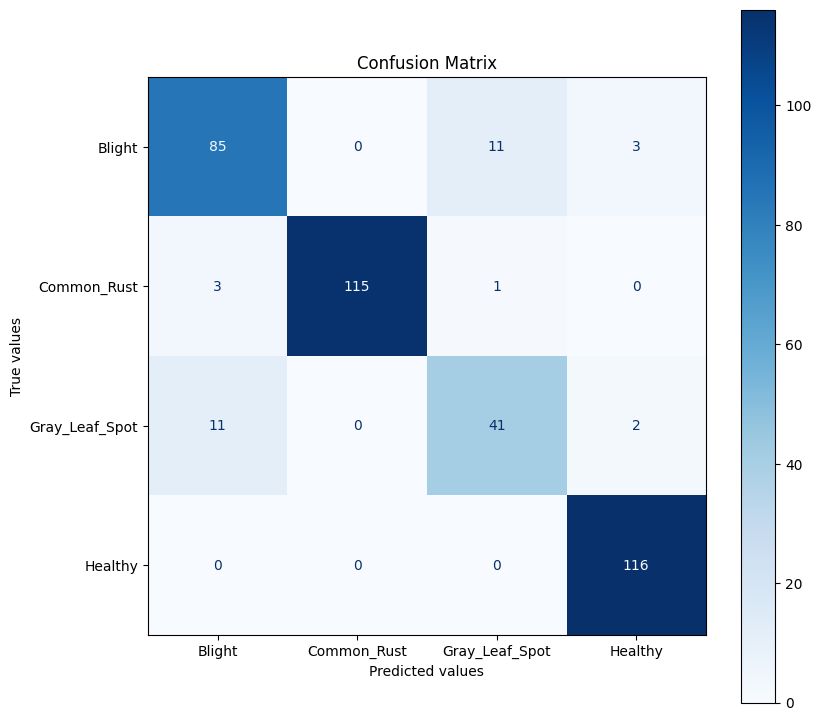

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

fig, ax = plt.subplots(figsize=(9,9))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', ax = ax)
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted Values")
class_names = ["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"]
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

## Accuracy and F1-Score
print(classification_report(y_test,y_pred, target_names = class_names))
acc_x = accuracy_score(y_test, y_pred)

print(f'Accuracy: {round(acc_x, 3)}%')

## **Prepare Data For Model Training and Validation**

In [ ]:
# Define the directories for the training, validation, and testing data:
train_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_Aug/train/'
val_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_Aug/val/'
test_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_Aug/test/'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generators for the training, validation, and testing data:
batch_size = 128
img_dims = 224

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224),
                                                    batch_size=batch_size, class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224),
                                                batch_size=batch_size, class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224),
                                                  batch_size=batch_size, class_mode='categorical')

Found 7622 images belonging to 4 classes.
Found 951 images belonging to 4 classes.
Found 945 images belonging to 4 classes.


## **Transfer Learning of VGG16**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
vgg_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in vgg_model.layers:
    layer.trainable = False

x = tf.keras.layers.Flatten()(vgg_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model_1 = tf.keras.models.Model(vgg_model.input, x)
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 5
history_1 = model_1.fit(train_generator, epochs=epochs,steps_per_epoch=train_generator.samples // batch_size, 
                        validation_data=val_generator,validation_steps=val_generator.samples // batch_size)


model_1.save('VGG_model_1.h5')
test_loss_1, test_acc_1 = model_1.evaluate(test_generator)
print('Test accuracy:', test_acc_1)

Epoch 1/5
39/39 [==============================] - 2213s 56s/step - loss: 0.8794 - accuracy: 0.7245 - val_loss: 0.2872 - val_accuracy: 0.8730
Epoch 2/5
39/39 [==============================] - 2151s 55s/step - loss: 0.3186 - accuracy: 0.8786 - val_loss: 0.1919 - val_accuracy: 0.9238
Epoch 3/5
39/39 [==============================] - 2160s 56s/step - loss: 0.2284 - accuracy: 0.9194 - val_loss: 0.1592 - val_accuracy: 0.9395
Epoch 4/5
39/39 [==============================] - 2161s 56s/step - loss: 0.1828 - accuracy: 0.9386 - val_loss: 0.1608 - val_accuracy: 0.9453
Epoch 5/5
5/5 [==============================] - 257s 51s/step - loss: 0.1504 - accuracy: 0.9445
Test accuracy: 0.9445325136184692


In [ ]:
model_1=load_model('/content/drive/MyDrive/project_phase_2/models/VGG_model_1.h5')

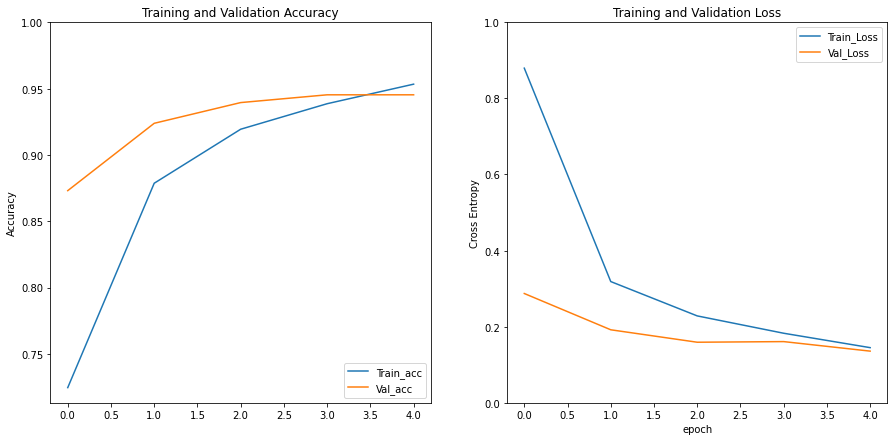

In [ ]:
### Loss and accuracy plot
acc_mob = history_1.history['accuracy']
val_acc_mob = history_1.history['val_accuracy']

loss_mob = history_1.history['loss']
val_loss_mob = history_1.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(acc_mob, label='Train_acc')
plt.plot(val_acc_mob, label='Val_acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_mob, label='Train_Loss')
plt.plot(val_loss_mob, label='Val_Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
input_test = test_dir
labels = os.listdir(input_test)
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_dims, img_dims)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
test_set_ = get_data(input_test)

## X and y test
X_test, y_test = [],[]
for feature, labels in test_set_:
  X_test.append(feature)
  y_test.append(labels)
## Convert the data in arrays 
X_test = np.array(X_test) / 255
y_test = np.array(y_test)

<ipython-input-11-e3d239c42c2b>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
y_pred = np.argmax(model_1.predict(X_test), axis = -1)

20/20 [==============================] - 253s 13s/step


                precision    recall  f1-score   support

        Blight       0.92      0.87      0.90       158
   Common_Rust       0.99      0.99      0.99       155
Gray_Leaf_Spot       0.90      0.92      0.91       159
       Healthy       0.96      0.98      0.97       159

      accuracy                           0.94       631
     macro avg       0.94      0.94      0.94       631
  weighted avg       0.94      0.94      0.94       631

Accuracy: 0.941%


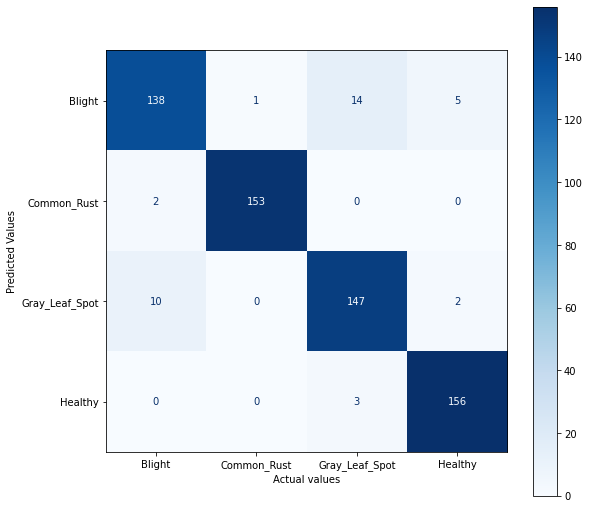

In [ ]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

fig, ax = plt.subplots(figsize=(9,9))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', ax = ax)
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted Values")
class_names = ["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"]
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

## Accuracy and F1-Score
print(classification_report(y_test,y_pred, target_names = class_names))
acc_x = accuracy_score(y_test, y_pred)

print(f'Accuracy: {round(acc_x, 3)}%')

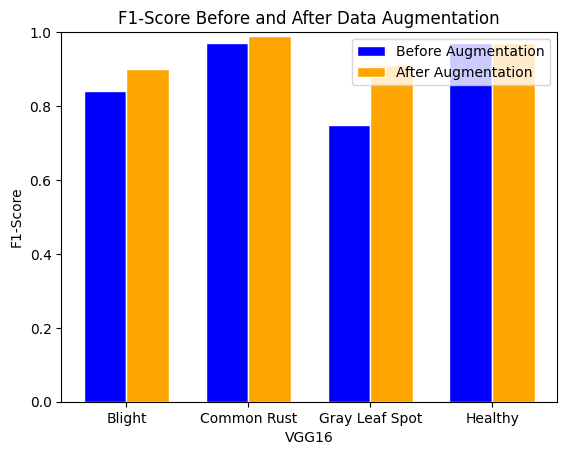

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels for the x-axis
labels = ['Blight', 'Common Rust', 'Gray Leaf Spot','Healthy']

# Define the f1 scores for each label before data augmentation
before_augmentation = [0.84, 0.97, 0.75,0.97]

# Define the f1 scores for each label after data augmentation
after_augmentation = [0.9, 0.99, 0.91,0.97]

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(before_augmentation))
r2 = [x + bar_width for x in r1]

# Plot the bars for f1 scores before and after data augmentation
plt.bar(r1, before_augmentation, color='blue', width=bar_width, edgecolor='white', label='Before Augmentation')
plt.bar(r2, after_augmentation, color='orange', width=bar_width, edgecolor='white', label='After Augmentation')

# Add x-axis labels and title
plt.xlabel('VGG16')
plt.ylabel('F1-Score')
plt.title('F1-Score Before and After Data Augmentation')

# Add x-axis tick labels
plt.xticks([r + bar_width/2 for r in range(len(before_augmentation))], labels)
plt.ylim(0,1)
# Add legend
plt.legend()

# Show the plot
plt.show()s